In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [3]:
base_dir = '/content/drive/MyDrive/brain_dataset/'
yes_dir = os.path.join(base_dir, 'yes')
no_dir = os.path.join(base_dir, 'no')

print('total have tumor images:', len(os.listdir(yes_dir)))
print('total no tumor images:', len(os.listdir(no_dir)))

total have tumor images: 155
total no tumor images: 98


In [4]:
yes_files = os.listdir(yes_dir)
print(yes_files[:10])

no_files = os.listdir(no_dir)
print(no_files[:10])

['Y14.jpg', 'Y104.jpg', 'Y120.JPG', 'Y111.JPG', 'Y20.jpg', 'Y147.JPG', 'Y192.JPG', 'Y114.JPG', 'Y187.jpg', 'Y161.JPG']
['N6.jpg', 'no 10.jpg', 'N2.JPG', 'N1.JPG', 'N19.JPG', '40 no.jpg', '8 no.jpg', '21 no.jpg', 'N3.jpg', 'no 1.jpg']


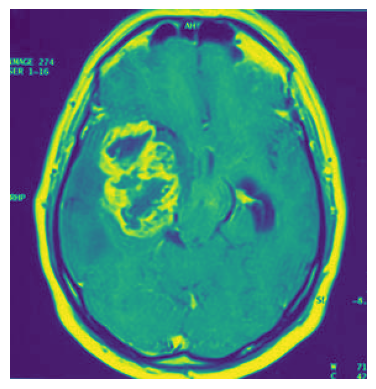

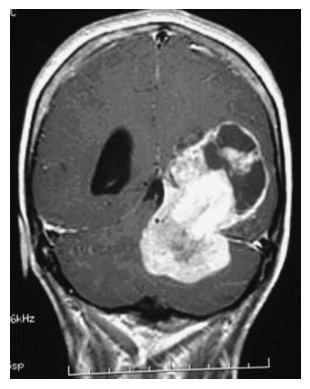

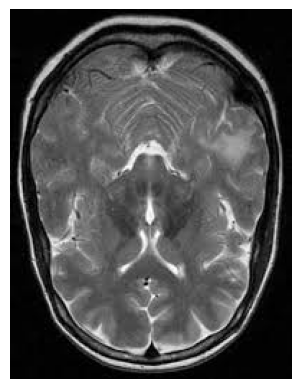

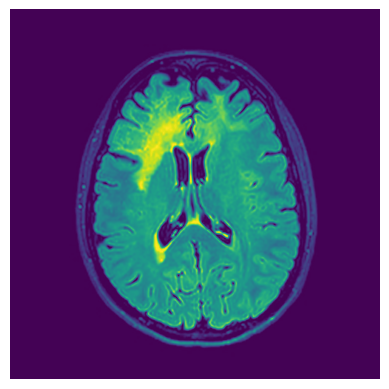

In [5]:
%matplotlib inline

pic_index = 2

next_yes = [os.path.join(yes_dir, fname)
                for fname in yes_files[pic_index-2:pic_index]]
next_no = [os.path.join(no_dir, fname)
                for fname in no_files[pic_index-2:pic_index]]


for i, img_path in enumerate(next_yes+next_no):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [6]:
dataset=[]
target=[]
for image_name in yes_files:
    image=cv2.imread(yes_dir + '/' +image_name)
    image=Image.fromarray(image)
    image=image.resize((64,64))
    dataset.append(np.array(image))
    target.append(1)

for image_name in no_files:
    image=cv2.imread(no_dir + '/' + image_name)
    image=Image.fromarray(image)
    image=image.resize((64,64))
    dataset.append(np.array(image))
    target.append(0)

In [7]:
data = np.array(dataset)
target = np.array(target)

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,target,test_size=0.05,random_state=True)

In [9]:
def data_augmenter():

    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE

    return data_augmentation

def preprocess_data(X):
    X_p = tf.keras.applications.resnet50.preprocess_input(X)
    return X_p

In [10]:
def resnet_model(X, augmentation=data_augmenter()):
    '''
    classification model
    '''

#     input_shape = X[0].shape

    model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=X[0].shape)

    model.trainable = False

    inputs = tf.keras.Input(shape=X[0].shape)

    x = augmentation(inputs)

    x = preprocess_data(x)

    x = model(x, training= False)

    x = tfl.GlobalAveragePooling2D()(x)
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.4)(x)

    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)

    outputs = prediction_layer(x)
    mod = tf.keras.Model(inputs, outputs)

    return mod

In [11]:
resNet = resnet_model(X_train, augmentation=data_augmenter())

94765736/94765736 [==============================] - 0s 0us/step


In [12]:
resNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 64, 64, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [13]:
base_learning_rate = 0.0001
resNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
initial_epochs = 50
history = resNet.fit(X_train,Y_train, validation_data=(X_test,Y_test), epochs=initial_epochs)

Epoch 1/50
8/8 [==============================] - 16s 390ms/step - loss: 2.3649 - accuracy: 0.3792 - val_loss: 1.0455 - val_accuracy: 0.5385
Epoch 2/50
8/8 [==============================] - 0s 26ms/step - loss: 1.9389 - accuracy: 0.4417 - val_loss: 1.0256 - val_accuracy: 0.5385
Epoch 3/50
8/8 [==============================] - 0s 26ms/step - loss: 1.7167 - accuracy: 0.4583 - val_loss: 1.0982 - val_accuracy: 0.3846
Epoch 4/50
8/8 [==============================] - 0s 26ms/step - loss: 1.4775 - accuracy: 0.4750 - val_loss: 1.1778 - val_accuracy: 0.4615
Epoch 5/50
8/8 [==============================] - 0s 26ms/step - loss: 1.3587 - accuracy: 0.5208 - val_loss: 1.2140 - val_accuracy: 0.3846
Epoch 6/50
8/8 [==============================] - 0s 25ms/step - loss: 1.3844 - accuracy: 0.5375 - val_loss: 1.2092 - val_accuracy: 0.3846
Epoch 7/50
8/8 [==============================] - 0s 26ms/step - loss: 1.3935 - accuracy: 0.5292 - val_loss: 1.1640 - val_accuracy: 0.4615
Epoch 8/50
8/8 [=========

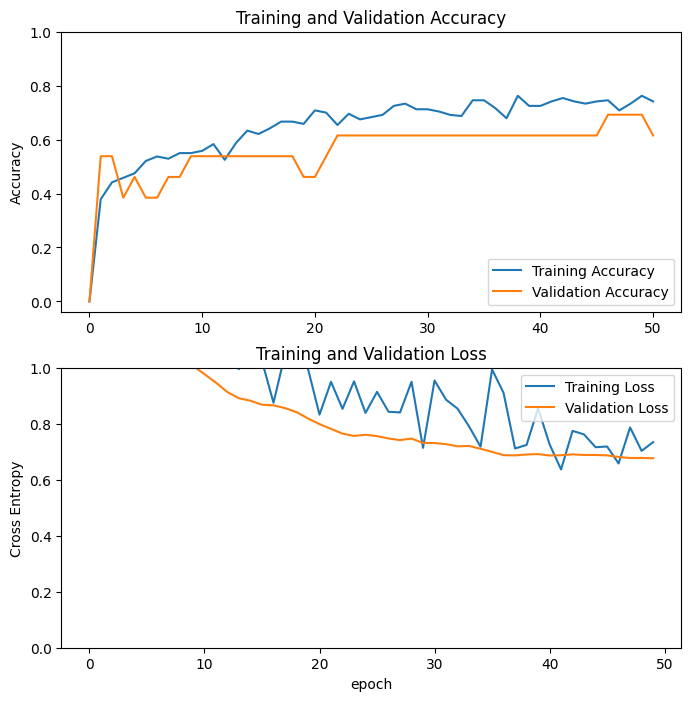

In [15]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
def resnet_model_2(X, augmentation=data_augmenter()):
    '''
    classification model
    '''

#     input_shape = X[0].shape

    model_2 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=X[0].shape)

    # Fine-tune from this layer onwards
    fine_tune_at = 165


    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model_2.layers[:fine_tune_at]:
        #print('Layer ' + layer.name + ' frozen.')
        layer.trainable = False

    inputs = tf.keras.Input(shape=X[0].shape)

    x = augmentation(inputs)

    x = preprocess_data(x)

    x = model_2(x)

    x = tfl.GlobalAveragePooling2D()(x)
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.6)(x)

    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1,activation="sigmoid")

    outputs = prediction_layer(x)
    mod_2 = tf.keras.Model(inputs, outputs)

    return mod_2

In [17]:
resNet_2 = resnet_model_2(X_train, augmentation=data_augmenter())

In [18]:
resNet_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 tf.__operators__.getitem_1   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [19]:
resNet_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
initial_epochs = 50
history_2 = resNet_2.fit(X_train,Y_train, validation_data=(X_test,Y_test), epochs=initial_epochs)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 10s 205ms/step - loss: 1.1986 - accuracy: 0.6208 - val_loss: 2.2036 - val_accuracy: 0.4615
Epoch 2/50
8/8 [==============================] - 0s 26ms/step - loss: 0.8898 - accuracy: 0.6667 - val_loss: 1.8288 - val_accuracy: 0.5385
Epoch 3/50
8/8 [==============================] - 0s 28ms/step - loss: 0.6948 - accuracy: 0.7875 - val_loss: 1.5510 - val_accuracy: 0.5385
Epoch 4/50
8/8 [==============================] - 0s 28ms/step - loss: 0.5590 - accuracy: 0.7792 - val_loss: 1.3809 - val_accuracy: 0.5385
Epoch 5/50
8/8 [==============================] - 0s 31ms/step - loss: 0.5744 - accuracy: 0.7542 - val_loss: 1.2625 - val_accuracy: 0.5385
Epoch 6/50
8/8 [==============================] - 0s 29ms/step - loss: 0.5015 - accuracy: 0.8417 - val_loss: 1.0612 - val_accuracy: 0.4615
Epoch 7/50
8/8 [==============================] - 0s 29ms/step - loss: 0.5125 - accuracy: 0.7958 - val_loss: 0.9856 - val_accuracy: 0.4615
Epoch 8/50
8/8 [====================

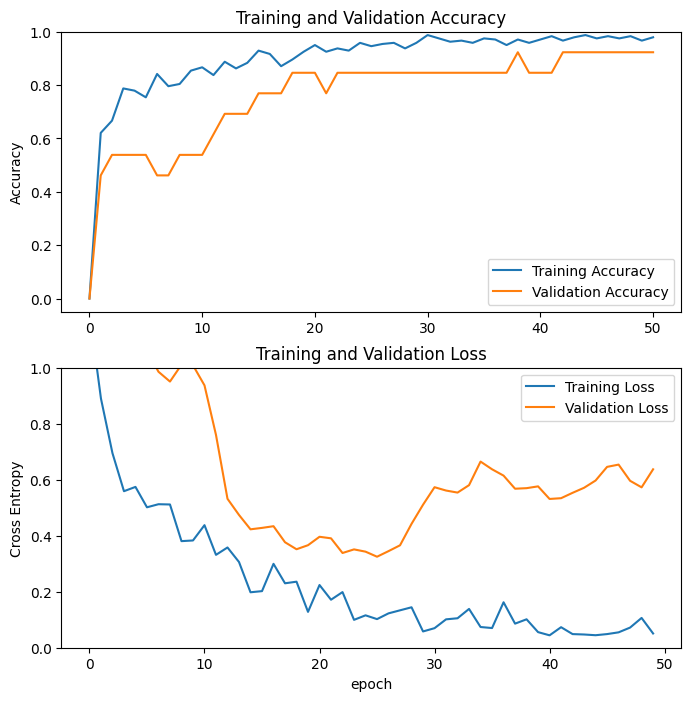

In [21]:
acc = [0.] + history_2.history['accuracy']
val_acc = [0.] + history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()